## 데이터 로드 및 확인

In [1]:
import numpy as np
datasets = np.load('npz/localization.npz', allow_pickle=True)
images, numbers, coordinates = datasets['images'], datasets['numbers'], datasets['coordinates']

print(images.shape, numbers.shape, coordinates.shape)
print(images.max(), images.min())
print(coordinates[2500])

(2588, 24, 32) (2588,) (2588, 4)
255 0
[ 8 10 20 22]


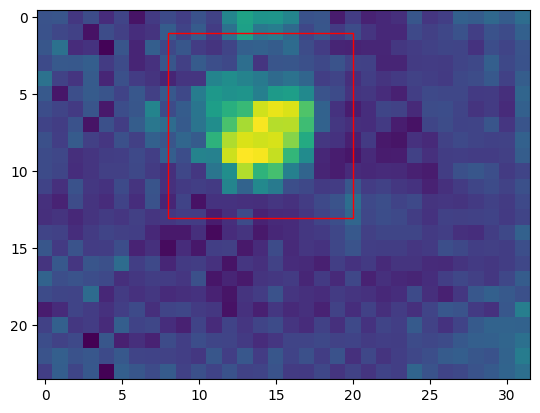

In [2]:
import matplotlib.pyplot as plt

def draw_bounding_box_from_vertices(image, vertices):
    xmin, xmax = vertices[0::2]
    ymin, ymax = vertices[1::2]
    
    rect_x = xmin
    rect_y = ymin
    rect_w = xmax - xmin
    rect_h = ymax - ymin

    rect = plt.Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
    plt.axes().add_patch(rect)
    plt.imshow(image)
    plt.show()

draw_bounding_box_from_vertices(images[700], coordinates[700])

## tfrecord 파일 만들기

In [3]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = int(images.shape[0] * 0.7)
N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'LocalizationLog'
print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)


shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/localization')
os.makedirs(tfr_dir, exist_ok = True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

2024-01-09 13:51:58.012954: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 13:51:58.056339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 13:51:58.769578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           2588
N_TRAIN:          1811
N_VAL:            777


In [4]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

In [5]:
for idx in train_idx_list:
    bbox = coordinates[idx]
    
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]

    xc = (xmin + xmax) / 2
    yc = (ymin + ymax) / 2

    x = xc / IMG_SIZE_WIDTH
    y = yc / IMG_SIZE_HEIGHT

    w = (xmax - xmin) / IMG_SIZE_WIDTH
    h = (ymax - ymin) / IMG_SIZE_HEIGHT

    image = images[idx]
    bimage = image.tobytes()

    example = tf.train.Example(features = tf.train.Features(feature = {
        'image': _bytes_feature(bimage),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))

    writer_train.write(example.SerializeToString())
writer_train.close()

2024-01-09 13:52:09.937778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-09 13:52:09.939493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-09 13:52:09.940983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-09 13:52:09.942468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [6]:
for idx in val_idx_list:
    bbox = coordinates[idx]
    
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]

    xc = (xmin + xmax) / 2
    yc = (ymin + ymax) / 2

    x = xc / IMG_SIZE_WIDTH
    y = yc / IMG_SIZE_HEIGHT

    w = (xmax - xmin) / IMG_SIZE_WIDTH
    h = (ymax - ymin) / IMG_SIZE_HEIGHT

    image = images[idx]
    bimage = image.tobytes()

    example = tf.train.Example(features = tf.train.Features(feature = {
        'image': _bytes_feature(bimage),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))

    writer_val.write(example.SerializeToString())
writer_val.close()

## Image Localization 모델 작성

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
N_EPOCHS = 100
N_BATCH = 7
LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = { 
        'image': tf.io.FixedLenFeature([], tf.string),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'w': tf.io.FixedLenFeature([], tf.float32),
        'h': tf.io.FixedLenFeature([], tf.float32)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) / 255.

    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)

    return image, gt

In [8]:
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function,
                                  num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function,
                              num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True)

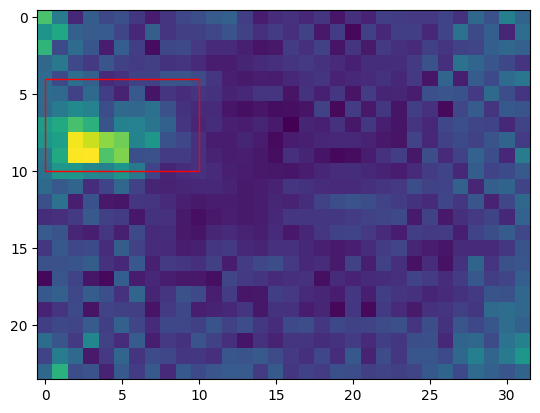

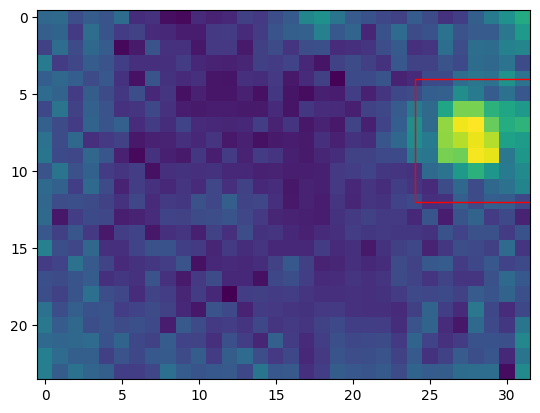

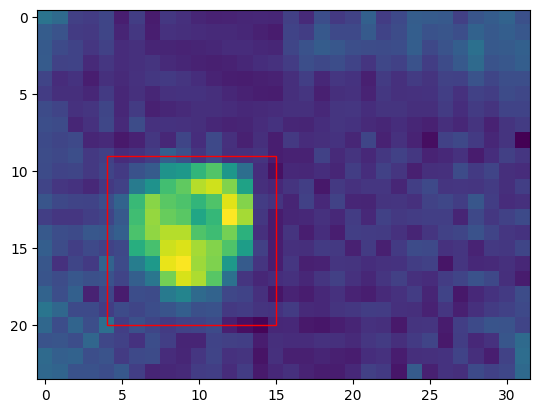

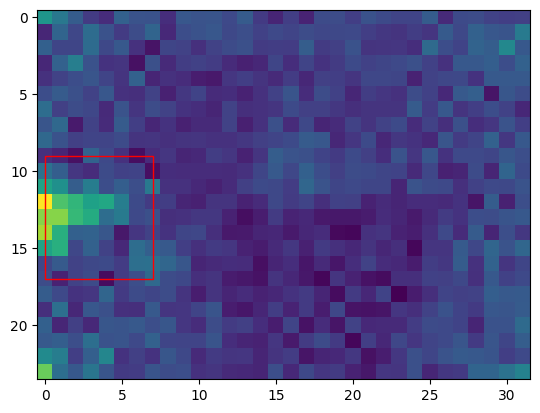

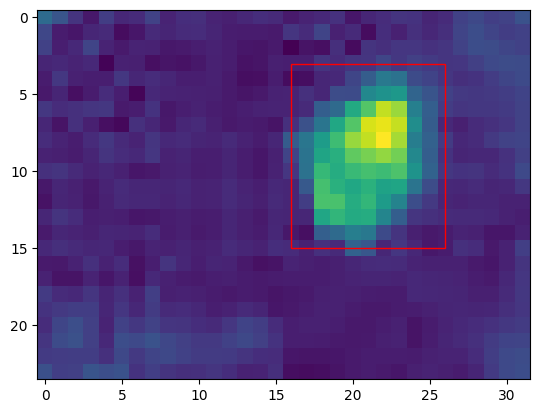

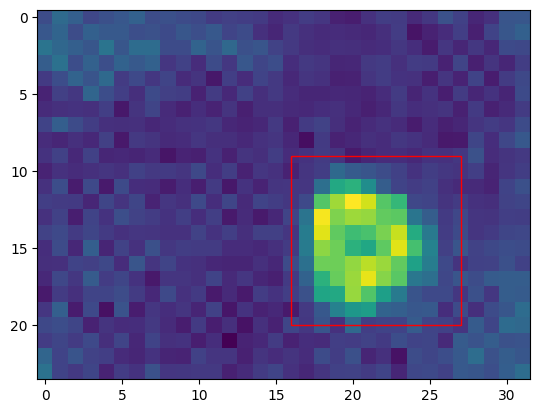

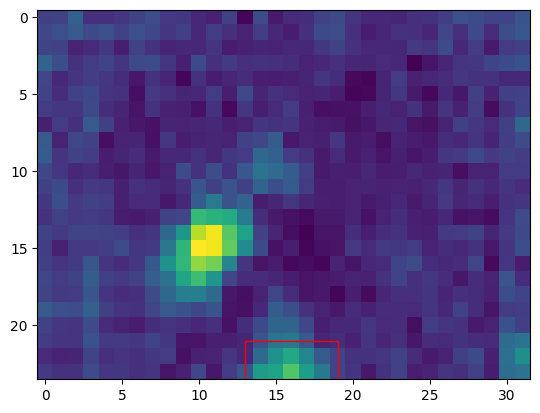

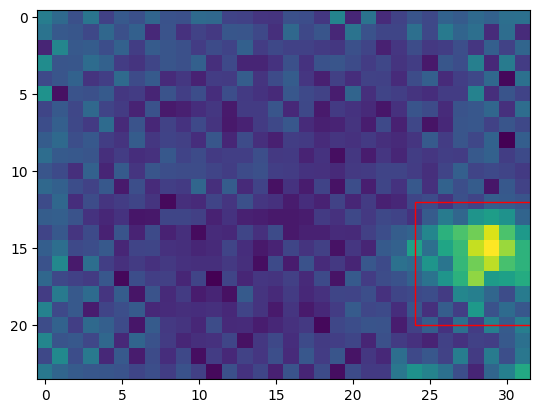

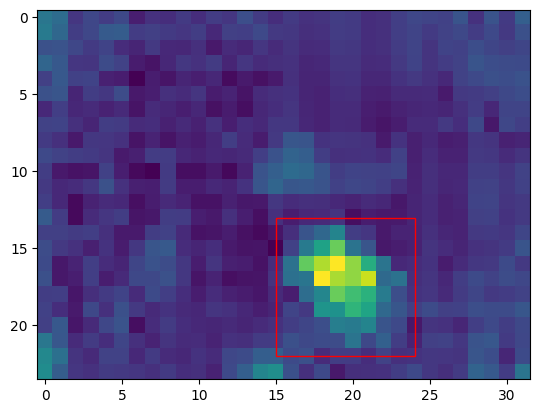

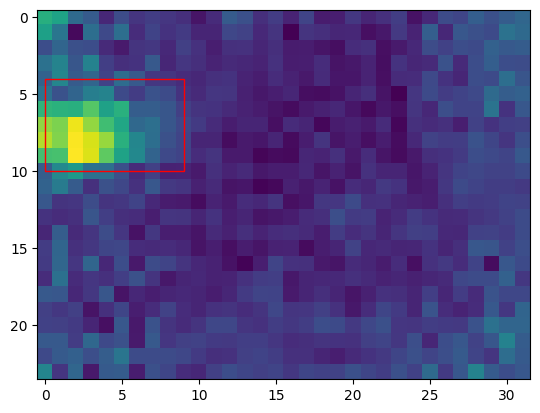

In [9]:
# img, gt = next(iter(train_dataset.take(1).unbatch()))

# for img, gt in train_dataset.take(1):
#     print(gt.shape)
#     print(gt[:, 0].shape)
#     print(gt[0].shape)


for image, gt in val_dataset.take(10):
    x = gt[:, 0]
    y = gt[:, 1]
    w = gt[:, 2]
    h = gt[:, 3]

    xmin = x[0].numpy() - w[0].numpy() / 2.
    ymin = y[0].numpy() - h[0].numpy() / 2.

    rect_x = int(xmin * IMG_SIZE_WIDTH)
    rect_y = int(ymin * IMG_SIZE_HEIGHT)
    rect_w = int(w[0].numpy() * IMG_SIZE_WIDTH)
    rect_h = int(h[0].numpy() * IMG_SIZE_HEIGHT)

    rect = plt.Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()


In [10]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.layers import Add

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def __call__(self, input_shape=(24, 32, 1)):
        inputs_image = Input(shape=input_shape)
        upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (3, 3), padding = 'same')(inputs_image)
        block_1 = self.feature_extraction_block(upsample_layer, 3, 5,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 3, 5,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 3, 5, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 3, 5, 'block_4')
        block_3_output = self.feature_extraction_block(block_2_output, 3, 3,'block_5')



        latent = Flatten()(block_3_output)
        latent = Dense(64, activation='relu', dtype='float32')(latent)
        latent = Dropout(0.2)(latent)
        number_output = Dense(4, activation='sigmoid', name='number_output', dtype='float32')(latent)

        model = Model(inputs_image, number_output)
        return model

In [11]:
class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, img_size_width, img_size_height, name='iou_metric', **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.img_size_width = img_size_width
        self.img_size_height = img_size_height
        self.iou_sum = self.add_weight(name="iou_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        x, y, w, h = y_true[:, 0], y_true[:, 1], y_true[:, 2], y_true[:, 3]
        pred_x, pred_y, pred_w, pred_h = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]

        xmin = (x - w / 2.) * self.img_size_width
        ymin = (y - h / 2.) * self.img_size_height
        xmax = (x + w / 2.) * self.img_size_width
        ymax = (y + h / 2.) * self.img_size_height

        pred_xmin = (pred_x - pred_w / 2.) * self.img_size_width
        pred_ymin = (pred_y - pred_h / 2.) * self.img_size_height
        pred_xmax = (pred_x + pred_w / 2.) * self.img_size_width
        pred_ymax = (pred_y + pred_h / 2.) * self.img_size_height

        w_inter = tf.maximum(tf.minimum(xmax, pred_xmax) - tf.maximum(xmin, pred_xmin), 0)
        h_inter = tf.maximum(tf.minimum(ymax, pred_ymax) - tf.maximum(ymin, pred_ymin), 0)

        inter = w_inter * h_inter
        union = (xmax - xmin) * (ymax - ymin) + (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin) - inter

        iou = tf.math.divide_no_nan(inter, union)
        iou_sum_batch = tf.reduce_sum(iou)

        self.iou_sum.assign_add(iou_sum_batch)
        self.total_samples.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))


    def result(self):
        return tf.math.divide_no_nan(self.iou_sum, self.total_samples)

    def reset_states(self):
        self.iou_sum.assign(0.)
        self.total_samples.assign(0.)


In [12]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall

backbone = BackBone()
model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, 
              loss=['mse'], 
              metrics=['accuracy', IoUMetric(IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT), Precision(), Recall()])

checkpoint = ModelCheckpoint('v4_backbone_localization_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 72, 96, 6)            60        ['input_1[0][0]']             
 anspose)                                                                                         
                                                                                                  
 block_1 (Conv2D)            (None, 72, 96, 3)            165       ['conv2d_transpose[0][0]']    
                                                                                                  
 batch_normalization (Batch  (None, 72, 96, 3)            12        ['block_1[0][0]']         

In [13]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = LOG_DIR
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [14]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=N_EPOCHS,
    verbose = 1,
    callbacks=[checkpoint, tensorboard_callback]
)
# tensorboard --logdir=LocalizationLog --bind_all

Epoch 1/100


2024-01-09 13:52:14.376136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-09 13:52:15.731292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-09 13:52:16.631253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-09 13:52:16.633936: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7b50077d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 13:52:16.633954: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-09 13:52:16.633959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExec

    256/Unknown - 13s 16ms/step - loss: 0.0943 - accuracy: 0.4922 - iou_metric: 0.0933 - precision: 1.0000 - recall: 0.3365

/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py:2620: UserWarning: Metric IoUMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_accuracy improved from -inf to 0.64994, saving model to v4_backbone_localization_model.h5


2024-01-09 13:52:26.163098: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13422691498620015331
2024-01-09 13:52:26.163176: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 729514947075145098
/home/gpuadmin/anaconda3/envs/ssd/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


258/258 [==============================] - 14s 22ms/step - loss: 0.0942 - accuracy: 0.4928 - iou_metric: 0.0931 - precision: 1.0000 - recall: 0.3360 - val_loss: 0.0856 - val_accuracy: 0.6499 - val_iou_metric: 0.0903 - val_precision: 1.0000 - val_recall: 0.6232
Epoch 2/100
256/258 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.7093 - iou_metric: 0.2186 - precision: 1.0000 - recall: 0.2937
Epoch 2: val_accuracy improved from 0.64994 to 0.74903, saving model to v4_backbone_localization_model.h5
258/258 [==============================] - 5s 20ms/step - loss: 0.0578 - accuracy: 0.7093 - iou_metric: 0.2188 - precision: 1.0000 - recall: 0.2933 - val_loss: 0.0661 - val_accuracy: 0.7490 - val_iou_metric: 0.1302 - val_precision: 1.0000 - val_recall: 0.2085
Epoch 3/100
258/258 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.7652 - iou_metric: 0.2933 - precision: 1.0000 - recall: 0.2728
Epoch 3: val_accuracy improved from 0.74903 to 0.82754, saving 

1/1 [==============================] - 0s 219ms/step


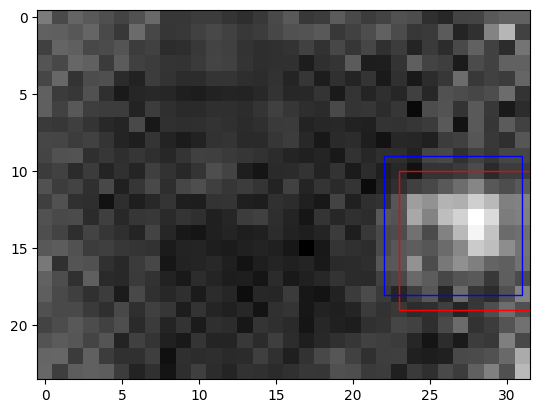

1/1 [==============================] - 0s 28ms/step


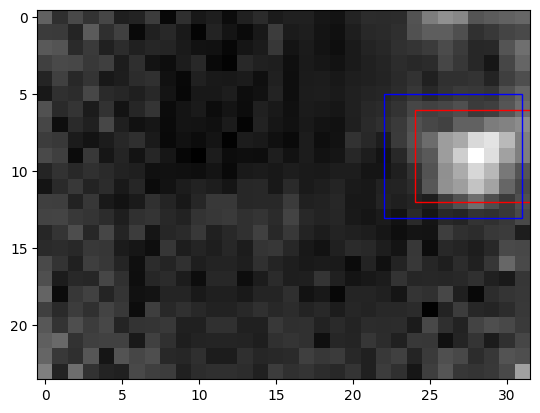

1/1 [==============================] - 0s 28ms/step


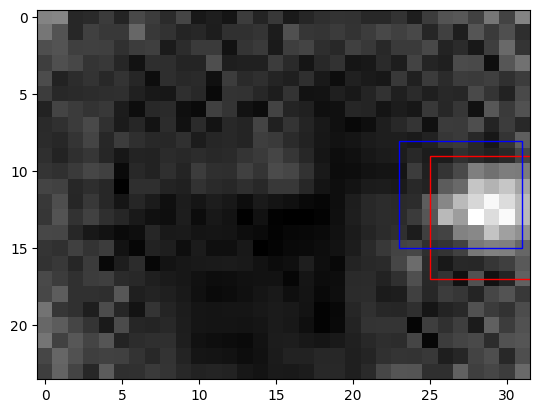

1/1 [==============================] - 0s 28ms/step


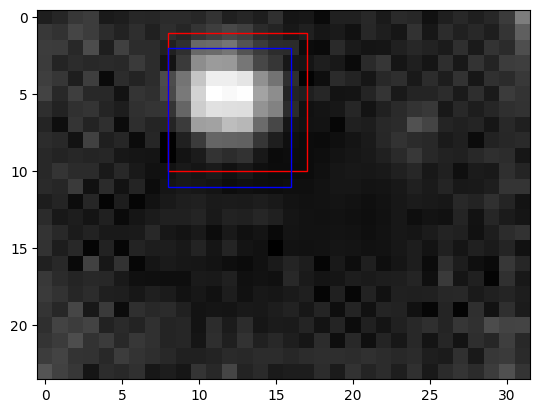

1/1 [==============================] - 0s 28ms/step


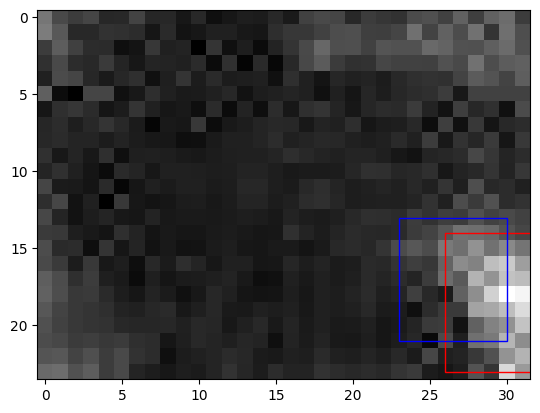

1/1 [==============================] - 0s 28ms/step


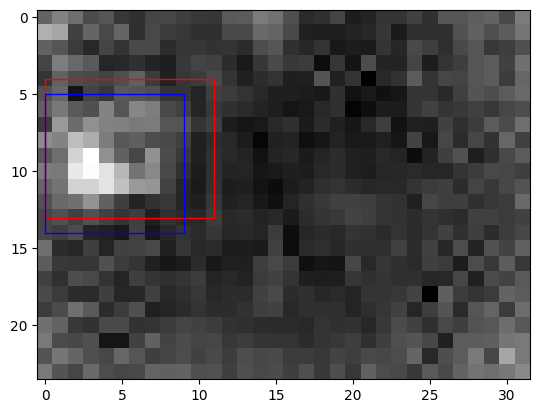

1/1 [==============================] - 0s 27ms/step


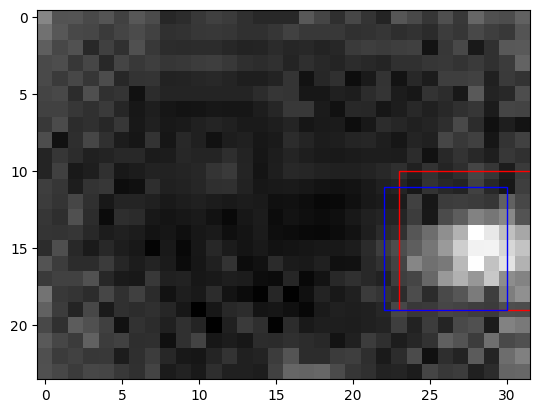

1/1 [==============================] - 0s 27ms/step


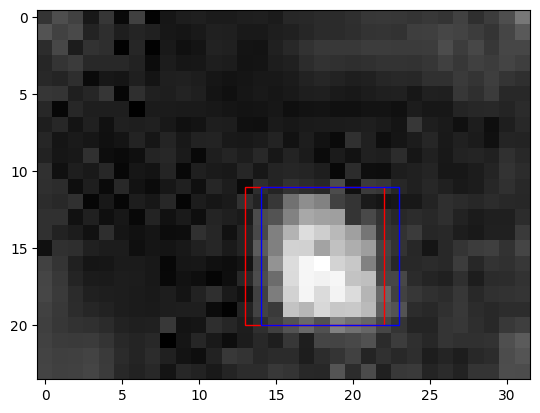

1/1 [==============================] - 0s 28ms/step


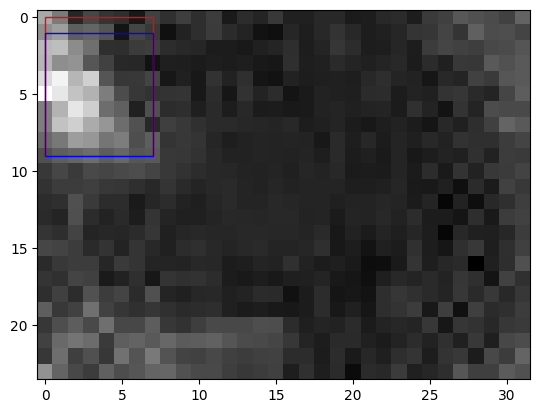

1/1 [==============================] - 0s 27ms/step


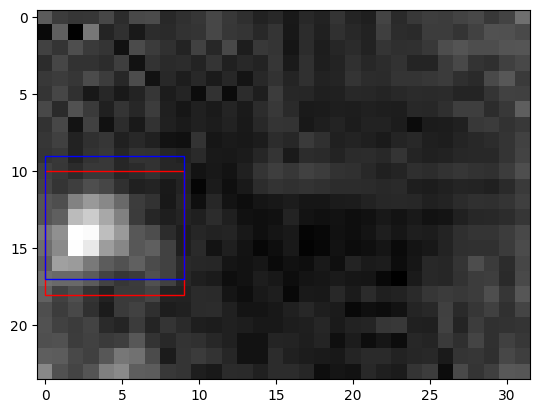

In [15]:
idx = 1
for val_data, val_gt in val_dataset.take(10):
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    xmin = x[idx].numpy() - w[idx].numpy() / 2.
    ymin = y[idx].numpy() - h[idx].numpy() / 2.

    rect_x = int(xmin * IMG_SIZE_WIDTH)
    rect_y = int(ymin * IMG_SIZE_HEIGHT)
    rect_w = int(w[idx].numpy() * IMG_SIZE_WIDTH)
    rect_h = int(h[idx].numpy() * IMG_SIZE_HEIGHT)

    rect = plt.Rectangle((rect_x, rect_y), rect_w, rect_h, fill = False, color = 'red')
    ax = plt.gca()
    ax.add_patch(rect)
    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]



    pred_xmin = pred_x[idx] - pred_w[idx] / 2.
    pred_ymin = pred_y[idx] - pred_h[idx] / 2.

    pred_rect_x = int(pred_xmin * IMG_SIZE_WIDTH)
    pred_rect_y = int(pred_ymin * IMG_SIZE_HEIGHT)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE_WIDTH)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE_HEIGHT)

    pred_rect = plt.Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h, fill = False, color = 'blue')
    ax.add_patch(pred_rect)
    plt.imshow(val_data[idx], cmap = 'gray')
    plt.show()

## IOU 계산

In [17]:
avg_iou = 0

for val_data, val_gt in val_dataset:
    x = val_gt[:, 0]
    y = val_gt[:, 1]
    w = val_gt[:, 2]
    h = val_gt[:, 3]

    prediction = model.predict(val_data)
    pred_x = prediction[:, 0]
    pred_y = prediction[:, 1]
    pred_w = prediction[:, 2]
    pred_h = prediction[:, 3]


    for idx in range(N_BATCH):
        xmin = int((x[idx].numpy() - w[idx].numpy() / 2.) * IMG_SIZE_WIDTH)
        ymin = int((y[idx].numpy() - h[idx].numpy() / 2.) * IMG_SIZE_HEIGHT)
        xmax = int((x[idx].numpy() + w[idx].numpy() / 2.) * IMG_SIZE_WIDTH)
        ymax = int((y[idx].numpy() + h[idx].numpy() / 2.) * IMG_SIZE_HEIGHT)

        W = xmax - xmin
        H = ymax - ymin

        pred_xmin = int((pred_x[idx] - pred_w[idx] / 2.) * IMG_SIZE_WIDTH)
        pred_ymin = int((pred_y[idx] - pred_h[idx] / 2.) * IMG_SIZE_HEIGHT)
        pred_xmax = int((pred_x[idx] + pred_w[idx] / 2.) * IMG_SIZE_WIDTH)
        pred_ymax = int((pred_y[idx] + pred_h[idx] / 2.) * IMG_SIZE_HEIGHT)

        pred_W = pred_xmax - pred_xmin
        pred_H = pred_ymax - pred_ymin

        if xmin > pred_xmax or xmax < pred_xmin:
            continue
        if ymin > pred_ymax or ymax < pred_ymin:
            continue


        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        inter = w_inter * h_inter

        union = (W * H + pred_W * pred_H) - inter

        iou = inter / union
        avg_iou += iou / N_VAL

print(avg_iou)
    

1/1 [==============================] - 0s 28ms/step
0.6829128161199601
